# Подгрузка

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import sys
from pathlib import Path

project_root = Path().resolve()
sys.path.append(str(project_root))

from filters.spatter import *

In [13]:
my_filter = MySpatter()
my_filter.set_params({})

# Первый способ

In [17]:
# values we need to set
needed_quantities = {'std':3, 'intensity':3, 'gauss_sigma':3} # сколько хотим сечений сетки по каждому параметру
needed_count = 20 # сколько хотим по итогу видосов > 1
min_psnr = 12 # в целом можно оставлять для любых фильтров
max_psnr = 50 # в целом можно оставлять для любых фильтров

In [ ]:
# create a map for video parameters and run them
from itertools import product

my_params = my_filter.get_ranges()

for elem in my_params.keys():
    left, right = my_params[elem]
    my_params[elem] = [left + i * (right - left) / (needed_quantities[elem] + 1) for i in range(1, needed_quantities[elem] + 1)]

with open(psnr_file, 'a') as ughhh:
    all_combinations = list(product(*my_params.values())) # create a map of params
    for combination in all_combinations:
        param_dict = dict(zip(my_params.keys(), combination))
        my_filter.set_params(param_dict)
        my_filter.apply_filter_video(input_path='videos/crowd_run_short_1920x1080_50.yuv')
        res = my_filter.apply_filter_video(input_path='videos/crowd_run_short_1920x1080_50.yuv')
        ughhh.write(f"std={std}intensity={intensity}gauss_sigma={gauss_sigma}psnr={res}\n")

In [2]:
sample_yuv_frames('videos/crowd_run_short_1920x1080_50.yuv', 'videos/shrt.yuv', 1920, 1080, num_frames=30)

Saved 30 frames to videos/shrt.yuv in YUV format


In [ ]:
#didn't check this one
with open(psnr_file, 'r') as file:
    lines = file.readlines()
lines = [line.strip() for line in lines]
psnrs = [float(line.split('=')[-1]) for line in lines]

# now we have psnr values and need to fill the gaps by using psnr analyze
min_psnr = max(min(psnrs), min_psnr)
max_psnr = min(max(psnrs), max_psnr)
needed_psnrs = [min_psnr + i * (max_psnr - min_psnr) / (needed_count - 1) for i in range(needed_count)]

#delete videos with too low or too high psnr values
i = 0
while i < len(psnrs):
    if not (x >= min_psnr and x <= max_psnr):
        os.remove('videos/' + lines[i].split('psnr')[0] + '.yuv'): # you can use os.join(...) 
        del lines[i]
        del psnrs[i]
    i += 1


for needed_psnr in needed_psnrs:
    ind, closest = min(list(enumerate(psnrs)), key=lambda x: abs(x[1] - needed_psnr))
    new_psnrs = []
    new_lines = []
    #check if the closest(from needed_psnrs) is actually close
    if needed_psnr != min(needed_psnrs, key=lambda x: abs(x - closest)):
        study = start_optimization(partial(my_filter.get_objective, input_path='videos/shrt.yuv', output_path='videos/res.yuv', needed_psnr=psnr), n_trials = 150, n_jobs = 1,
                                   tpe_sampler = tpe_sampler)
        my_filter.set_params(study.best_trial.params)
        res = my_filter.apply_filter_video(input_path='videos/crowd_run_short_1920x1080_50.yuv')
        new_psnrs.append(res)
        new_lines.append(f"std={std}intensity={intensity}gauss_sigma={gauss_sigma}psnr={res}")
    else:
        new_psnrs.append(closest)
        new_lines.append(lines[ind])
        
#rewrite the psnr log file as we have changed the video set
with open(psnr_file, 'w') as file:
    for line in new_lines:
        file.write(line + '\n')

for bad_line in set(lines).difference(new_lines): # lines that used to be there but are no longer ther => delete their videos
    os.remove('videos/' + bad_line.split('psnr')[0] + '.yuv'): # you can use os.join(...) 

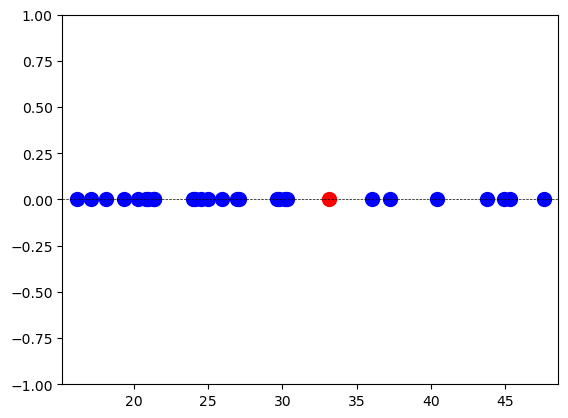

[33.15226999999999]

In [22]:
# в реализации описанной сергеем не нужно
psnr_analyze('psnr_before.txt')

# Второй способ

In [ ]:
sample_yuv_frames('videos/crowd_run_short_1920x1080_50.yuv', 'videos/shrt.yuv', 1920, 1080, num_frames=30)

In [ ]:
tpe_sampler = optuna.samplers.TPESampler(
        n_startup_trials= 8, # объем разведки. Всегда настраивайте!
        n_ei_candidates=15, # влияет на "точность шага"
)
psnrs = [15,17.5, 20, 22.5,  25, 27.5, 30, 32.5, 35, 37.5, 40, 42.5, 45, 47.5]
for psnr in psnrs:
    study = start_optimization(partial(my_filter.get_objective, input_path='videos/shrt.yuv', output_path='videos/res.yuv', needed_psnr=psnr), n_trials = 150, n_jobs = 1,
                           tpe_sampler = tpe_sampler)
    my_filter.set_params(study.best_trial.params)
    my_filter.apply_filter_video(input_path='videos/crowd_run_short_1920x1080_50.yuv')

In [ ]:
psnr_file = 'smth.txt'
my_filter.first_set(psnr_file)
sample_yuv_frames('videos/crowd_run_short_1920x1080_50.yuv', 'videos/shrt.yuv', 1920, 1080, num_frames=30)
tpe_sampler = optuna.samplers.TPESampler(
        n_startup_trials= 8, # объем разведки. Всегда настраивайте!
        n_ei_candidates=15, # влияет на "точность шага"
)
added_params = []
for psnr in psnr_analyze(psnr_file):
    study = start_optimization(partial(my_filter.get_objective, input_path='videos/shrt.yuv', needed_psnr=psnr), n_trials = 150, n_jobs = 1,
                           tpe_sampler = tpe_sampler)
    my_filter.set_params(study.best_trial.params)
    psnr = my_filter.apply_filter_video(input_path='videos/crowd_run_short_1920x1080_50.yuv')
    added_params.append([study.best_trial.params, psnr])

В целом почти уверен что второй способ как и проще в реализации, так и работает быстрее и ошибка по сетке у него будет очевидно меньше потому что мы используем оптюну.